In [1]:
import numpy as np
import healpy as hp
import pysm3
import matplotlib.pyplot as plt
from fgbuster.component_model import CMB, Dust, Synchrotron
from fgbuster.observation_helpers import get_instrument, get_observation, standardize_instrument
from fgbuster.mixingmatrix import MixingMatrix
from fgbuster.separation_recipes import multi_res_comp_sep, adaptive_comp_sep
from cmbdb import cmbdb

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.weight"] = "light"
plt.rc('text', usetex=True)

## FGBuster

The necessary functions for component separation with spatial variations are in the `clusters` branch

### Define instrumental set-up and sky

Define instrument, with proper format

In [2]:
instrument = get_instrument('LiteBIRD')
print(instrument)
instrument['depth_i'] = instrument['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instrument)

    frequency  depth_p  fwhm  f_sky    status reference       type experiment
0        40.0    37.42  70.5    1.0  forecast    IMO-v1  satellite   LiteBIRD
1        50.0    33.46  58.5    1.0  forecast    IMO-v1  satellite   LiteBIRD
2        60.0    21.31  51.1    1.0  forecast    IMO-v1  satellite   LiteBIRD
3        68.0    16.87  47.1    1.0  forecast    IMO-v1  satellite   LiteBIRD
4        78.0    12.07  43.8    1.0  forecast    IMO-v1  satellite   LiteBIRD
5        89.0    11.30  41.5    1.0  forecast    IMO-v1  satellite   LiteBIRD
6       100.0     6.56  37.8    1.0  forecast    IMO-v1  satellite   LiteBIRD
7       119.0     4.58  33.6    1.0  forecast    IMO-v1  satellite   LiteBIRD
8       140.0     4.79  30.8    1.0  forecast    IMO-v1  satellite   LiteBIRD
9       166.0     5.57  28.9    1.0  forecast    IMO-v1  satellite   LiteBIRD
10      195.0     5.85  28.6    1.0  forecast    IMO-v1  satellite   LiteBIRD
11      235.0    10.79  24.7    1.0  forecast    IMO-v1  satelli

Plot PySM `d1s1` model properties

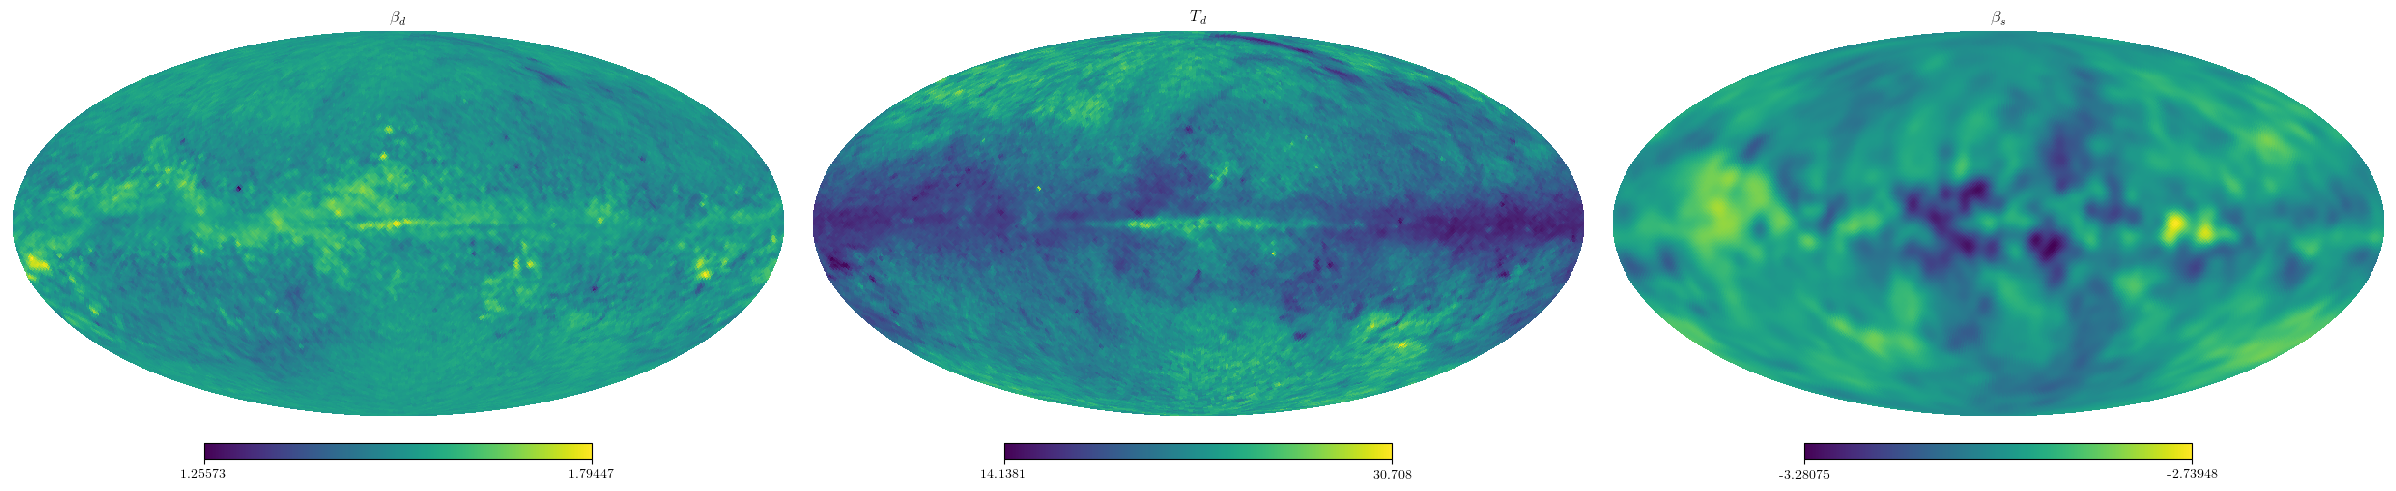

In [11]:
nside = 64 #simulated sky nside
synch_model, dust_model = "s1", "d1" # with spatial variations

### Get PySM parameter templates
sky = pysm3.Sky(nside=nside, preset_strings=[dust_model])
sky = pysm3.Sky(nside=nside, preset_strings=["d1", "s1"])

# Dust properties
dust = sky.components[0]
Bd_pysm = dust.mbb_index.value
Td_pysm = dust.mbb_temperature.value

# Synch properties
synch = sky.components[1]
Bs_pysm = synch.pl_index.value

fig = plt.figure(figsize=(24, 5))
hp.mollview(Bd_pysm, sub=(1, 3, 1), title=r'$\beta_{d}$')
hp.mollview(Td_pysm, sub=(1, 3, 2), title=r'$T_{d}$')
hp.mollview(Bs_pysm, sub=(1, 3, 3), title=r'$\beta_{s}$')

Simulate sky with PySM models

In [25]:
# Noiseless frequency maps of each components (by default in CMB units)
CMB_maps = get_observation(instrument, 'c1', nside=nside)
synch_maps = get_observation(instrument, synch_model, nside=nside)
dust_maps = get_observation(instrument, dust_model, nside=nside)

# Coadd maps
freq_maps = CMB_maps + synch_maps + dust_maps 

# Replace previous steps with this to produce noisy maps
# freq_maps = get_observation(instrument, 'c1'+synch_model+dust_model, nside=nside, noise=True)

print(CMB_maps.shape, synch_maps.shape, dust_maps.shape)

(15, 3, 49152) (15, 3, 49152) (15, 3, 49152)


### Set up component separation parameters

Define comp sep parameters

In [23]:
# Which mixing matrix structure to use -> which parameters to fit
components = [CMB(), Dust(nu0=100.), Synchrotron(nu0=100.)]

# Optimization parameters for the likelihood minimization
tol_ = 1e-18
options = {'disp': False, 'gtol': tol_, 'eps': tol_, 'maxiter': 10000, 'ftol': tol_}
method = 'TNC' # Truncated Newtonian, others are possible but in our experience this gives the best performance

When including with spatial variations, we need to specify the parameters patch configuration

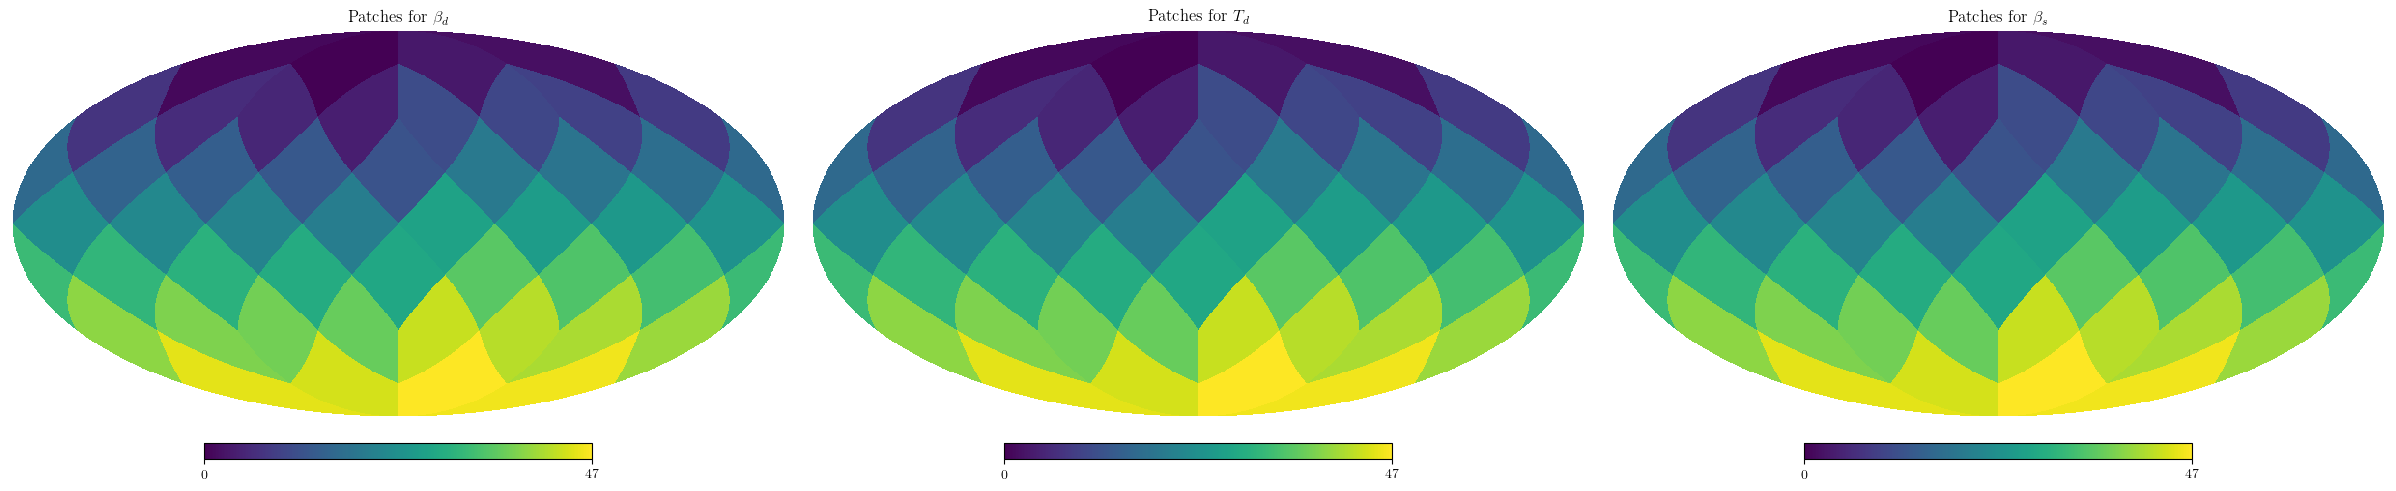

In [28]:
### Hp patches with same nside for all parameters
# nsides = np.array([2, 2, 2])
nsides = np.array([1, 0, 0])
n_patches = 12*nsides**2
patches_ids = np.array([hp.ud_grade(np.arange(n_patches[i]), nside) for i in np.arange(len(nsides))])

### Hp patches with different nside for each parameters
# nsides = np.array([32, 8, 4])
# n_patches = 12*nsides**2
# patches_ids = np.array([hp.ud_grade(np.arange(n_patches[i]), nside) for i in np.arange(len(nsides))])

### Plot patch_ids
fig_id = plt.figure(figsize=(24, 5))
hp.mollview(patches_ids[0], sub=(1, 3, 1), title=r'Patches for $\beta_{d}$')
hp.mollview(patches_ids[1], sub=(1, 3, 2), title=r'Patches for $T_{d}$')
hp.mollview(patches_ids[2], sub=(1, 3, 3), title=r'Patches for $\beta_{s}$')

### Run the component separation

Homogeneous sky and simple component separation so use `basic_comp_sep`

In [30]:
# Run comp sep and store results
result = adaptive_comp_sep(components, instrument, freq_maps, patches_ids, method=method, tol=tol_, options=options)
print("Success ?", bool(result.status))
print("Best fit parameters: ", result.x)
print("Sigma of the parameters:", np.sqrt(np.diag(result.Sigma)))

/home/cleloup/software/fgbuster/fgbuster/algebra.py:952: OptimizeWarning: Unknown solver options: maxiter
  res = sp.optimize.minimize(fun, *minimize_args, **minimize_kwargs)


KeyboardInterrupt: 

In [9]:
result.keys()

(3, 3, 49152)

### Exploit results

Output reconstructed component maps

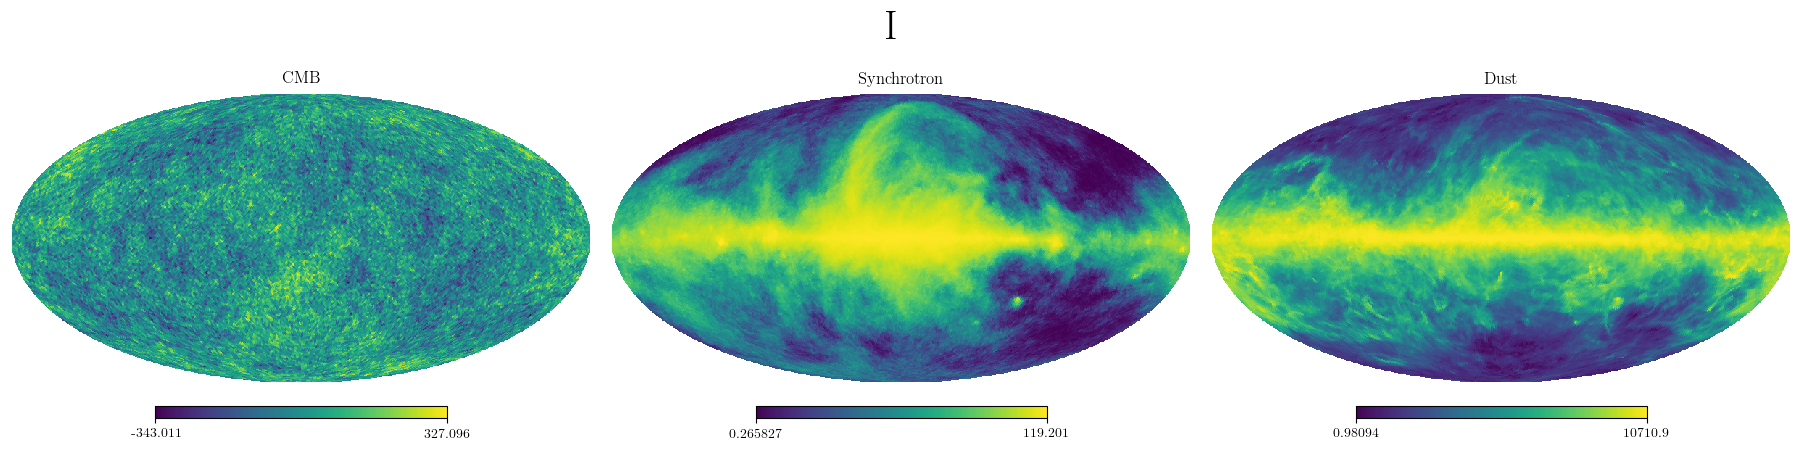

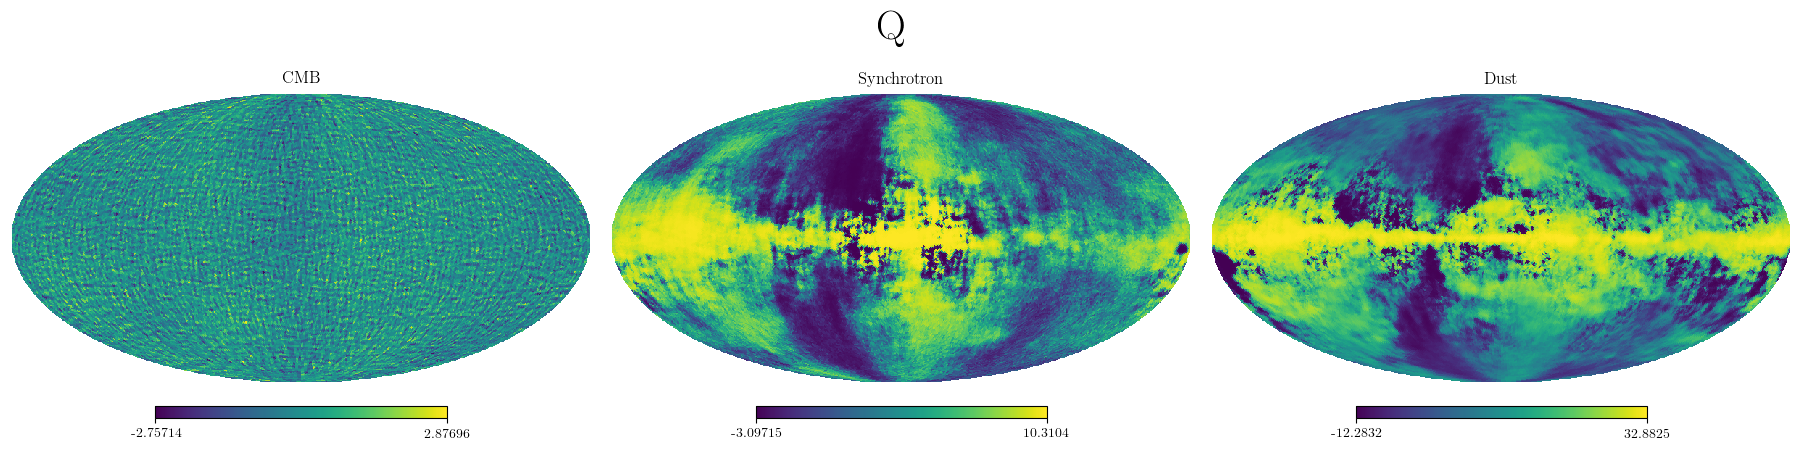

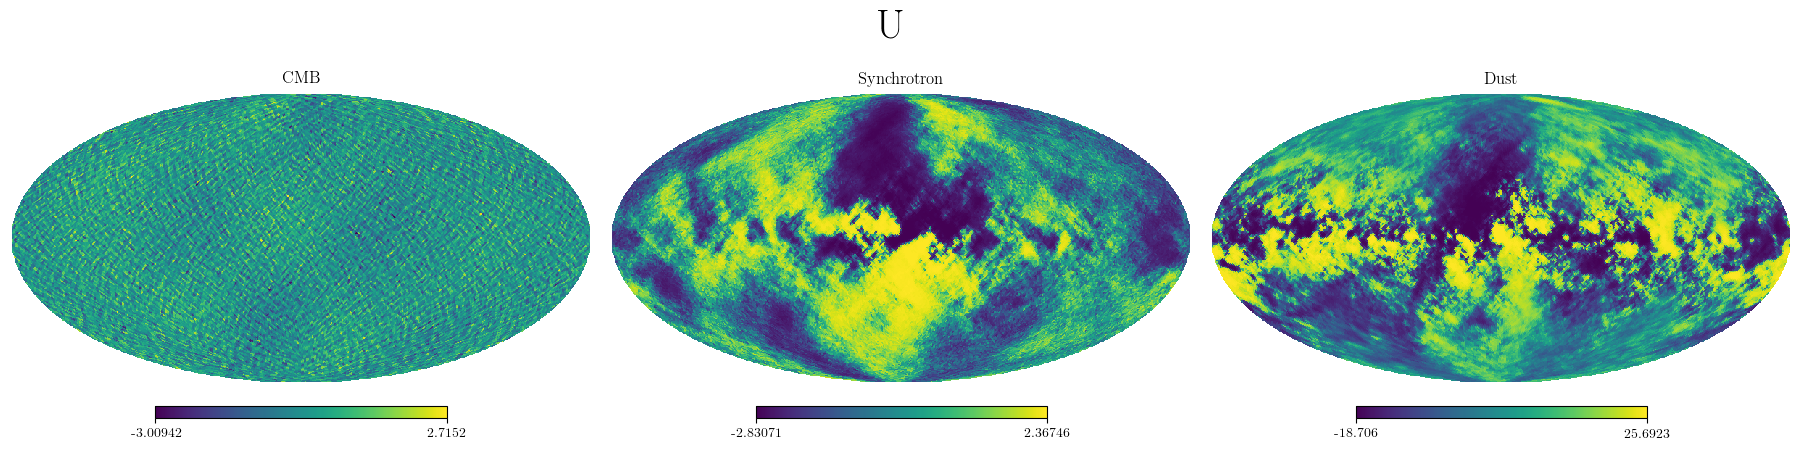

In [10]:
## Reconstructed CMB, Dust, Synch maps
rec_CMB_maps = result.s[0]
rec_synch_maps = result.s[2]
rec_dust_maps = result.s[1]

fig_temp = plt.figure(figsize=(18, 4.5), num=1)
fig_temp.suptitle('I', fontsize=30)
hp.mollview(rec_CMB_maps[0], sub=(1, 3, 1), fig=1, title='CMB')
hp.mollview(rec_synch_maps[0], sub=(1, 3, 2), fig=1, norm="hist", title='Synchrotron')
hp.mollview(rec_dust_maps[0], sub=(1, 3, 3), fig=1, norm="hist", title='Dust')
plt.show()

## Polarization templates (Q and U) for CMB, Dust, Synch
fig_Q = plt.figure(figsize=(18, 4.5), num=2)
fig_Q.suptitle('Q', fontsize=30)
hp.mollview(rec_CMB_maps[1], sub=(1, 3, 1), fig=2, title='CMB')
hp.mollview(rec_synch_maps[1], sub=(1, 3, 2), fig=2, norm="hist", title='Synchrotron')
hp.mollview(rec_dust_maps[1], sub=(1, 3, 3), fig=2, norm="hist", title='Dust')
plt.show()

fig_U = plt.figure(figsize=(18, 4.5), num=3)
fig_U.suptitle('U', fontsize=30)
hp.mollview(rec_CMB_maps[2], sub=(1, 3, 1), fig=3, title='CMB')
hp.mollview(rec_synch_maps[2], sub=(1, 3, 2), fig=3, norm="hist", title='Synchrotron')
hp.mollview(rec_dust_maps[2], sub=(1, 3, 3), fig=3, norm="hist", title='Dust')
plt.show()

Residual maps (relatively to the input maps)

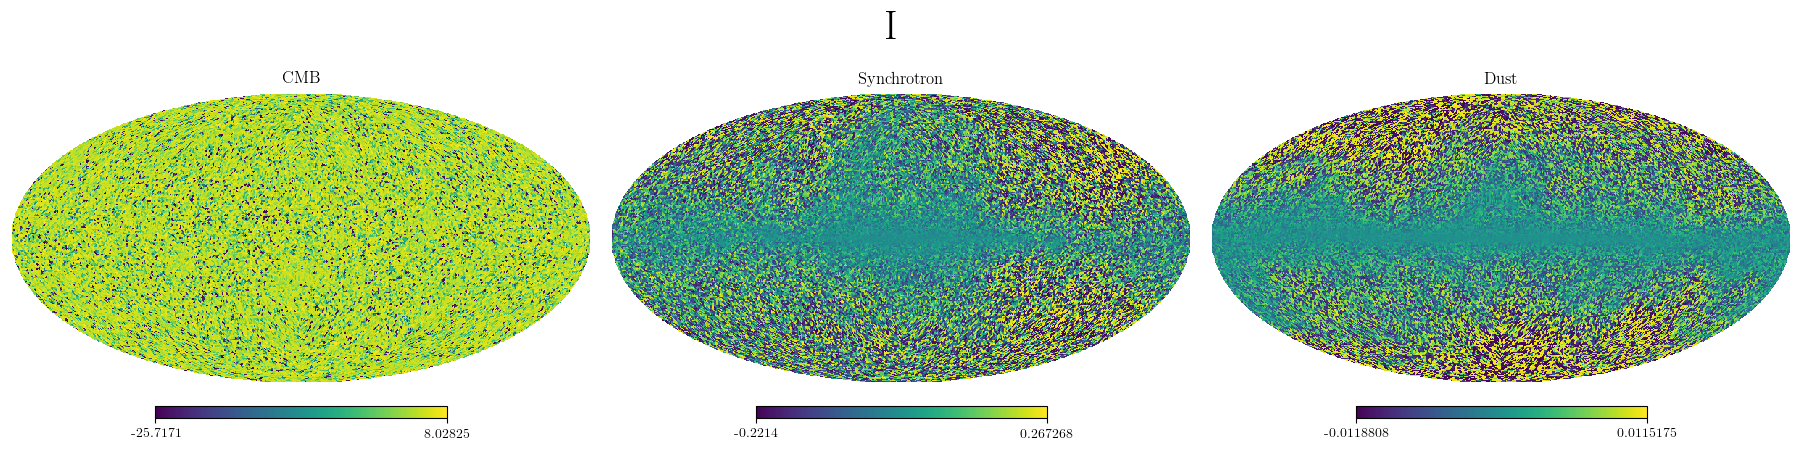

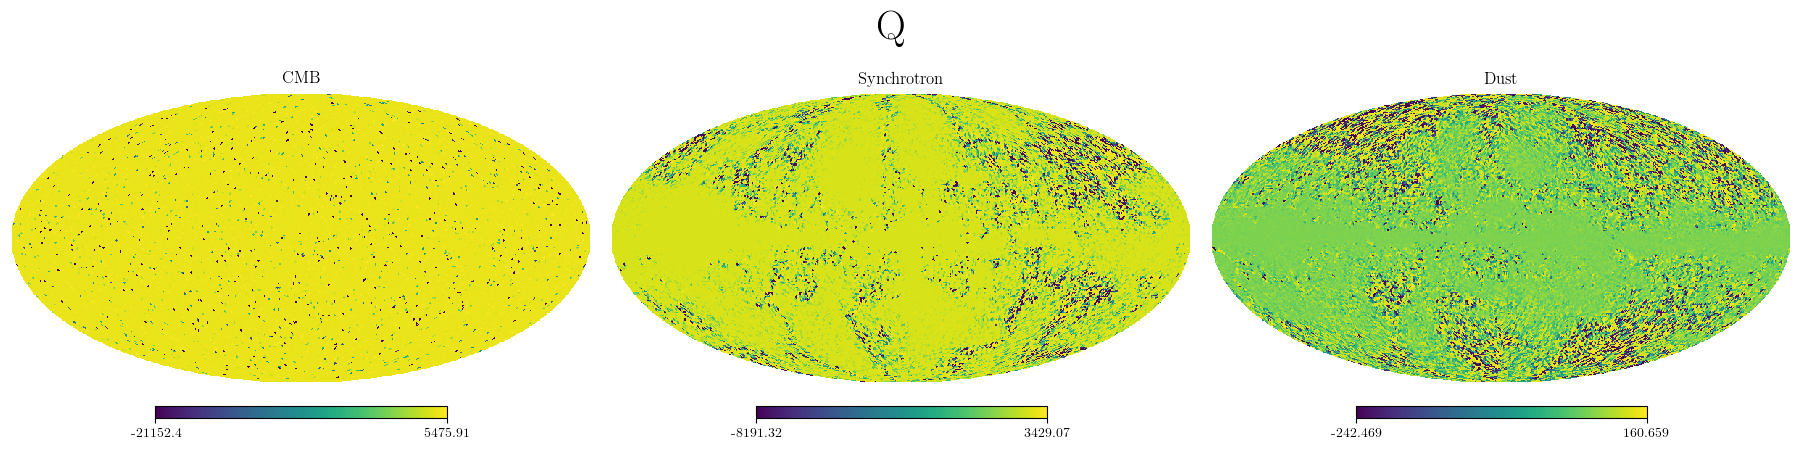

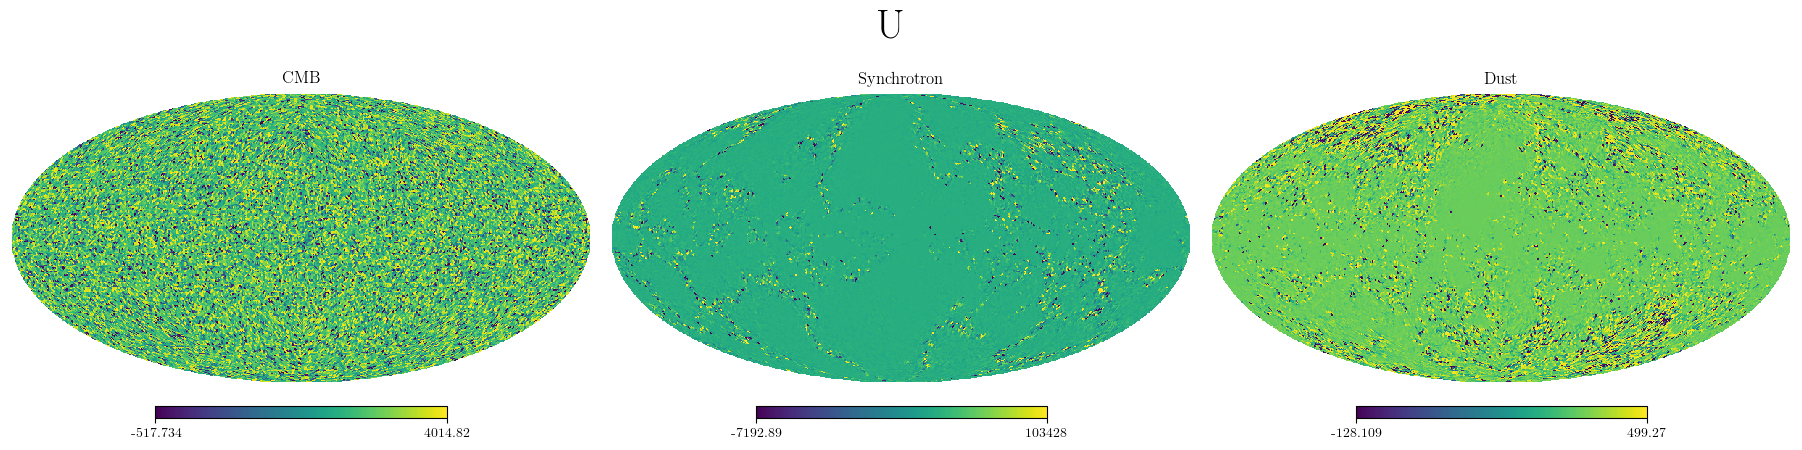

In [11]:
## Reconstructed CMB, Dust, Synch maps
res_CMB_maps = rec_CMB_maps - CMB_maps[6]
res_synch_maps = rec_synch_maps - synch_maps[6]
res_dust_maps = rec_dust_maps - dust_maps[6]

fig_temp = plt.figure(figsize=(18, 4.5), num=1)
fig_temp.suptitle('I', fontsize=30)
hp.mollview(res_CMB_maps[0]/CMB_maps[6,0], sub=(1, 3, 1), fig=1, title='CMB', norm="hist")
hp.mollview(res_synch_maps[0]/synch_maps[6,0], sub=(1, 3, 2), fig=1, norm="hist", title='Synchrotron')
hp.mollview(res_dust_maps[0]/dust_maps[6,0], sub=(1, 3, 3), fig=1, norm="hist", title='Dust')
plt.show()

## Polarization templates (Q and U) for CMB, Dust, Synch
fig_Q = plt.figure(figsize=(18, 4.5), num=2)
fig_Q.suptitle('Q', fontsize=30)
hp.mollview(res_CMB_maps[1]/CMB_maps[6,1], sub=(1, 3, 1), fig=2, title='CMB', norm="hist")
hp.mollview(res_synch_maps[1]/synch_maps[6,1], sub=(1, 3, 2), fig=2, norm="hist", title='Synchrotron')
hp.mollview(res_dust_maps[1]/dust_maps[6,1], sub=(1, 3, 3), fig=2, norm="hist", title='Dust')
plt.show()

fig_U = plt.figure(figsize=(18, 4.5), num=3)
fig_U.suptitle('U', fontsize=30)
hp.mollview(res_CMB_maps[2]/CMB_maps[6,2], sub=(1, 3, 1), fig=3, title='CMB', norm="hist")
hp.mollview(res_synch_maps[2]/synch_maps[6,2], sub=(1, 3, 2), fig=3, norm="hist", title='Synchrotron')
hp.mollview(res_dust_maps[2]/dust_maps[6,2], sub=(1, 3, 3), fig=3, norm="hist", title='Dust')
plt.show()

Produce residual power-spectra

In [12]:
Cl_res = hp.anafast(res_CMB_maps)[2, 2:2*nside]
Cl_res.shape

(126,)

Plot B-mode residuals and compare with CMB B modes

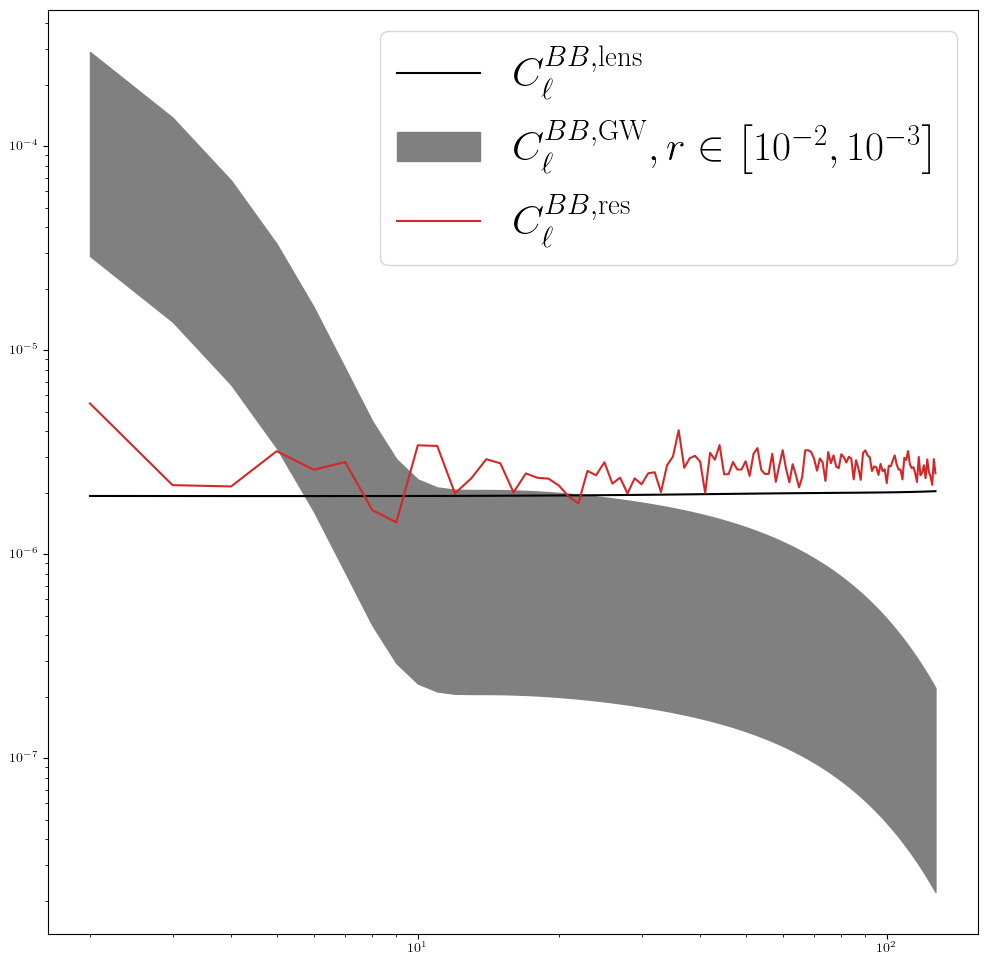

In [13]:
ell = np.arange(2, 2*nside)
Cl_lens = hp.read_cl("/home/cleloup/software/fgb_tutorials/templates/Cls_Planck2018_lensed_scalar.fits")[2, 2:2*nside] #only take B modes
Cl_prim = hp.read_cl("/home/cleloup/software/fgb_tutorials/templates/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")[2, 2:2*nside] #only take B modes

fig = plt.figure(figsize=(12, 12))
plt.xscale('log')
plt.yscale('log')
plt.plot(ell, Cl_lens, color='k', label=r'$C_{\ell}^{BB, {\rm lens}}$')
plt.fill_between(ell, 0.001*Cl_prim, 0.01*Cl_prim, color='gray', label=r'$C_{\ell}^{BB, {\rm GW}}, r \in \left[ 10^{-2}, 10^{-3} \right] $')
plt.plot(ell, Cl_res, color='tab:red', label=r'$C_{\ell}^{BB, {\rm res}}$')
plt.legend(loc="upper right", prop={'size':30})